In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import scipy.stats as stats
import matplotlib.pyplot as plt

from tqdm import tqdm
from matplotlib.lines import Line2D
from IPython.display import display, HTML


root_path = os.path.abspath(os.path.join(os.path.abspath(""), "../.."))

In [2]:
mpl.rcParams["font.size"] = 5
mpl.rcParams["axes.titlesize"] = 6
mpl.rcParams["xtick.labelsize"] = 5
mpl.rcParams["xtick.major.size"] = 2
mpl.rcParams["xtick.minor.size"] = 1.2
mpl.rcParams["ytick.labelsize"] = 5
mpl.rcParams["ytick.major.size"] = 2
mpl.rcParams["ytick.minor.size"] = 1.2
mpl.rcParams["lines.linewidth"] = 1.2
mpl.rcParams["lines.markersize"] = 2
mpl.rcParams["lines.markeredgewidth"] = 0.5
mpl.rcParams["boxplot.flierprops.markersize"] = 2
mpl.rcParams["boxplot.flierprops.markeredgewidth"] = 0.5
mpl.rcParams["legend.fontsize"] = 5

In [3]:
piQTLs = pd.read_csv(f'{root_path}/results/05_piQTL_tables/significant_piQTLs_results_with_genome_annotations_without_MTX_peaks.csv')
multiple_UTs = pd.read_csv(f'{root_path}/data/genotype_information/snps_annotations_genome-version-3-64-1_UTs.txt').rename(columns={"snp_id":"SNP"})
annotated_LDs = pd.read_csv(f'{root_path}/data/genotype_information/snps_annotations_genome-version-3-64-1_LD_annotated.txt').rename(columns={"snp_id":"SNP"})

#### Distribution of effect size in unstable transcripts (Figure 4)

In [4]:
UT_piQTLs = piQTLs.merge(multiple_UTs, on='SNP').reset_index(drop=True)

UT_piQTLs = UT_piQTLs [ UT_piQTLs['snps_annotations'] != 'ORF']
UT_piQTLs['snps_class_up_v2'] = [ UT_piQTLs['snps_annotations'][idx].split('_')[-1] for idx in UT_piQTLs.index ]

Text(0, 0.5, 'Absolute effect size')

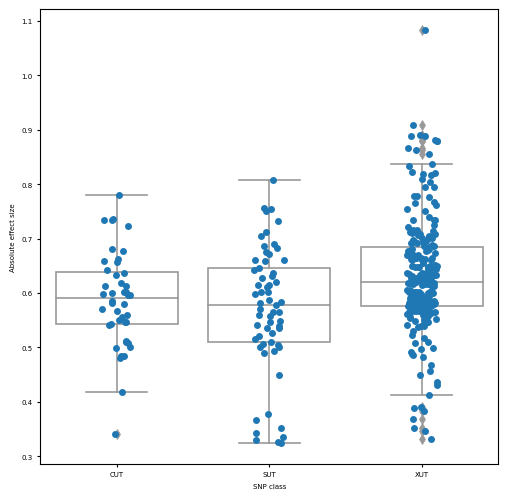

In [5]:
piQTLs = UT_piQTLs[UT_piQTLs['FDR'] < 0.05].reset_index(drop=True)

piQTLs['PPI'] = [ f"{piQTLs['Condition'][idx].split('_')[0]}:{piQTLs['Condition'][idx].split('_')[1]}" for idx in piQTLs.index ] 
piQTLs['DRUG'] = [ f"{piQTLs['Condition'][idx].split('_')[3]}" for idx in piQTLs.index ] 
piQTLs['CDT'] = [ f"{piQTLs['Condition'][idx].split('_')[2]}:{piQTLs['Condition'][idx].split('_')[3]}" for idx in piQTLs.index ] 
piQTLs['snps_class_up_v2'] = pd.Categorical(piQTLs['snps_class_up_v2'] , categories=['CUT','SUT','XUT'], ordered=True)
piQTLs = piQTLs[~piQTLs['SNP'].isin([10455, 10456, 10468])]

CM = 1/2.54 # centimeters in inches
f = plt.figure(figsize=(15*CM, 15*CM))
sns.boxplot(y=np.abs(piQTLs['Effect']), x=piQTLs['snps_class_up_v2'], color='white')
sns.stripplot(y=np.abs(piQTLs['Effect']), x=piQTLs['snps_class_up_v2'])
plt.xlabel('SNP class')
plt.ylabel('Absolute effect size')

# plt.savefig('../../figures/figure_4/effect_size_boxplot_UTs.png', format='png', dpi=300)
# plt.savefig('../../figures/figure_4/effect_size_boxplot_UTs.eps', format='eps', dpi=300)

In [6]:
piQTLs[(piQTLs['snps_annotations'] == 'CUT') & (np.abs(piQTLs['Effect']) > 1)].sort_values('Effect')[['SNP', 'Chr', 'Condition', 'Effect', '-log_pval', 'snps_annotations', 'snps_class_up_v2']]

,SNP,Chr,Condition,Effect,-log_pval,snps_annotations,snps_class_up_v2


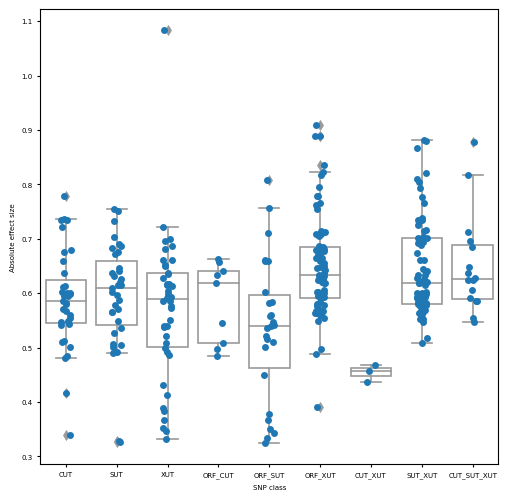

In [7]:
piQTLs['snps_annotations'] = pd.Categorical(piQTLs['snps_annotations'] , categories=['CUT', 'SUT', 'XUT', 'ORF_CUT', 'ORF_SUT', 'ORF_XUT', 'CUT_XUT', 'SUT_XUT','CUT_SUT_XUT' ], ordered=True)
piQTLs_without_outliers = piQTLs[~piQTLs['SNP'].isin([10455, 10456, 10468])]
f = plt.figure(figsize=(15*CM, 15*CM))

sns.boxplot(y=np.abs(piQTLs_without_outliers['Effect']), x=piQTLs_without_outliers['snps_annotations'], color='white')
sns.stripplot(y=np.abs(piQTLs_without_outliers['Effect']), x=piQTLs_without_outliers['snps_annotations'])
plt.xlabel('SNP class')
plt.ylabel('Absolute effect size')

plt.savefig(f'{root_path}/figures/figure_4/effect_size_boxplot_UTs_without_outliers.eps', format='eps', dpi=300)
# plt.savefig('../../figures/figure_4/effect_size_boxplot_UTs_without_outliers.png', format='png', dpi=300)

In [8]:
piQTLs[(piQTLs['snps_annotations'] == 'XUT') & (np.abs(piQTLs['Effect']) > 1)].sort_values('Effect')[['SNP', 'Chr', 'Condition', 'Effect', '-log_pval', 'snps_annotations', 'snps_class_up_v2']]

,SNP,Chr,Condition,Effect,-log_pval,snps_annotations,snps_class_up_v2
236,2835,5,SSH1_PIS1_MTX_5.FC,-1.083689,3.524915,XUT,XUT


In [9]:
UT_annotations_pairwaise_comparison = [] 

UTs_annotations = np.unique(piQTLs_without_outliers['snps_annotations'].dropna())
for i in range(len(UTs_annotations)):
    for j in range(i+1, len(UTs_annotations)):
        A = UTs_annotations[i]
        B = UTs_annotations[j]

        effect_A = np.abs(piQTLs_without_outliers[piQTLs_without_outliers['snps_annotations'] == A]['Effect'].values)
        effect_B = np.abs(piQTLs_without_outliers[piQTLs_without_outliers['snps_annotations'] == B]['Effect'].values)

        stat, pval = stats.ttest_ind(effect_A,effect_B)
        UT_annotations_pairwaise_comparison.append([A, B, stat, pval])

In [10]:
pd.DataFrame(UT_annotations_pairwaise_comparison, columns=['Annotation_A', 'Annotation_B', 't-test_statistic', 'p-value']).to_csv(f'{root_path}/results/UT_annotations_t-tests.csv', index=False)

In [11]:
piQTLs[(piQTLs['snps_annotations'].isin(['ORF_CUT', 'ORF_SUT', 'ORF_XUT', 'CUT_XUT', 'SUT_XUT', 'CUT_SUT_XUT']))].sort_values(['snps_annotations','Effect'])[['SNP', 'Chr', 'Condition', 'Effect', '-log_pval', 'snps_annotations', 'snps_class_up_v2']].to_csv(f'{root_path}/results/05_piQTL_tables/interesting_piQTLs/mutiple_UTs.csv', index=False)

___

#### Distribution of ranked effect size by genomic features

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


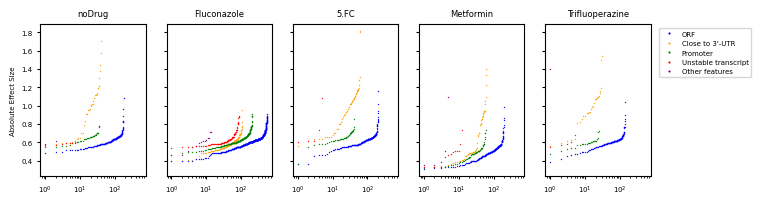

In [12]:
CM = 1/2.54 # centimeters in inches

class_color = {
    'ORF':'blue',
    'Close to 3\'-UTR':'orange',
    'Promoter':'green',
    'Unstable transcript':'red',
    'Other features':'purple'
    }

piQTLs = pd.read_csv(f'{root_path}/results/05_piQTL_tables/significant_piQTLs_results_with_genome_annotations_without_MTX_peaks.csv')
lumped_piQTLs = piQTLs.replace('Intergenic region', 'Other features')
lumped_piQTLs = lumped_piQTLs.replace('Non-coding RNA', 'Other features')
piQTLs = lumped_piQTLs[lumped_piQTLs['FDR'] < 0.05].reset_index(drop=True)
piQTLs = piQTLs[~piQTLs['SNP'].isin([10455, 10456, 10468])]

piQTLs['PPI'] = [ f"{piQTLs['Condition'][idx].split('_')[0]}:{piQTLs['Condition'][idx].split('_')[1]}" for idx in piQTLs.index ] 
piQTLs['DRUG'] = [ f"{piQTLs['Condition'][idx].split('_')[3]}" for idx in piQTLs.index ] 
piQTLs['CDT'] = [ f"{piQTLs['Condition'][idx].split('_')[2]}:{piQTLs['Condition'][idx].split('_')[3]}" for idx in piQTLs.index ] 

f, axes = plt.subplots(figsize=(20 * CM, 5 * CM), nrows=1, ncols=5, sharey=True, sharex=True)
i = 0
for DRUG in ['noDrug', 'Fluconazole', '5.FC', 'Metformin', 'Trifluoperazine' ]:
    T = piQTLs[piQTLs['Condition'].str.contains(DRUG)].reset_index(drop=True)
    T['abs_Effect'] = np.abs(T['Effect'])

    for CLASS in np.unique(T['snps_class_up']):
        TMP = T[T['snps_class_up'] == CLASS].sort_values('abs_Effect', ascending=True).reset_index(drop=True)

        sns.scatterplot(y=TMP['abs_Effect'], x=TMP.index, marker='.', linewidth=0, alpha = 0.9, color=class_color[CLASS], ax=axes[i])

        axes[i].set_ylabel('Absolute Effect Size')
        axes[i].set_xscale('log')
        axes[i].set_title(DRUG)
    i += 1

custom = [Line2D([], [], marker='.', color='blue', linestyle='None'),
        Line2D([], [], marker='.', color='orange', linestyle='None'),
        Line2D([], [], marker='.', color='green', linestyle='None'), 
        Line2D([], [], marker='.', color='red', linestyle='None'),
        Line2D([], [], marker='.', color='purple', linestyle='None')]

plt.legend(custom, ['ORF', 'Close to 3\'-UTR', 'Promoter', 'Unstable transcript', 'Other features'], bbox_to_anchor=(1.05, 1.0), loc='upper left')


plt.savefig(f'{root_path}/figures/figure_2/effect_size_distribution_all_snps_up_FDR_without_outliers.eps', format='eps', dpi=300)
# plt.savefig('../../figures/figure_2/effect_size_distribution_all_snps_up_FDR_without_outliers.png', format='png', dpi=300)


#### Fraction of piQTLs by genomic features and drugs

In [13]:
piQTLs = pd.read_csv(f'{root_path}/results/05_piQTL_tables/significant_piQTLs_results_with_genome_annotations_without_MTX_peaks.csv')
lumped_piQTLs = piQTLs.replace('Intergenic region', 'Other features')
lumped_piQTLs = lumped_piQTLs.replace('Non-coding RNA', 'Other features')
piQTLs = lumped_piQTLs[lumped_piQTLs['FDR'] < 0.05].reset_index(drop=True)
piQTLs = piQTLs[~piQTLs['SNP'].isin([10455, 10456, 10468])]

piQTLs['PPI'] = [ f"{piQTLs['Condition'][idx].split('_')[0]}:{piQTLs['Condition'][idx].split('_')[1]}" for idx in piQTLs.index ]
piQTLs['DRUG'] = [ f"{piQTLs['Condition'][idx].split('_')[3]}" for idx in piQTLs.index ]
piQTLs['CDT'] = [ f"{piQTLs['Condition'][idx].split('_')[2]}:{piQTLs['Condition'][idx].split('_')[3]}" for idx in piQTLs.index ]


lumped_annotated_LDs = annotated_LDs.replace('Intergenic region', 'Other features')
lumped_annotated_LDs = lumped_annotated_LDs.replace('Non-coding RNA', 'Other features')
lumped_annotated_LDs.groupby('snps_class_up').count()


total_by_class = pd.DataFrame(lumped_annotated_LDs.groupby(['snps_class_up']).count()['SNP']).reset_index()

fraction = pd.DataFrame(piQTLs.groupby(['DRUG', 'snps_class_up']).count()['SNP']).reset_index()
fraction['DRUG'] = pd.Categorical(fraction['DRUG'], categories=['noDrug', 'Fluconazole', '5.FC', 'Metformin', 'Trifluoperazine'], ordered=True)
fraction = fraction.merge(total_by_class, on=['snps_class_up'], suffixes=['_frac', '_total'])
fraction['snps_class_up'] = pd.Categorical(fraction['snps_class_up'], categories=['ORF', 'Close to 3\'-UTR', 'Promoter', 'Unstable transcript', 'Other features'], ordered=True)
fraction['frac'] = fraction['SNP_frac'] / fraction['SNP_total']
fraction = fraction.sort_values(['snps_class_up', 'DRUG'])


In [14]:
fraction

,DRUG,snps_class_up,SNP_frac,SNP_total,frac
9,noDrug,ORF,179,6314,0.028350
6,Fluconazole,ORF,560,6314,0.088692
5,5.FC,ORF,206,6314,0.032626
7,Metformin,ORF,198,6314,0.031359
8,Trifluoperazine,ORF,142,6314,0.022490
4,noDrug,Close to 3'-UTR,41,2114,0.019395
1,Fluconazole,Close to 3'-UTR,109,2114,0.051561
0,5.FC,Close to 3'-UTR,63,2114,0.029801
2,Metformin,Close to 3'-UTR,63,2114,0.029801
3,Trifluoperazine,Close to 3'-UTR,31,2114,0.014664


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


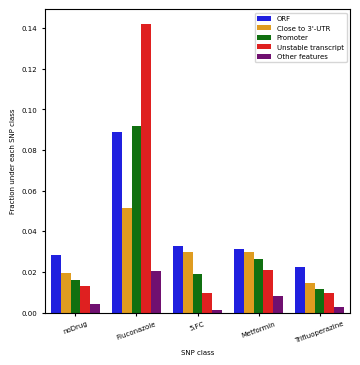

In [15]:
CM = 1/2.54 # centimeters in inches
class_color = {
    'ORF':'blue',
    'Close to 3\'-UTR':'orange',
    'Promoter':'green',
    'Unstable transcript':'red',
    'Other features':'purple'
    }

f = plt.figure(figsize=(10*CM, 10*CM))
sns.barplot(y=fraction['frac'], x=fraction['DRUG'], hue=fraction['snps_class_up'], palette=['blue', 'orange', 'green','red','purple'])
plt.xlabel('SNP class')
plt.ylabel('Fraction under each SNP class')
plt.xticks(rotation=20)
plt.legend(loc='upper right')

plt.savefig(f'{root_path}/figures/figure_2/piQTLs_distribution_fraction_without_outliers.eps', format='eps', dpi=300)
# plt.savefig('../../figures/FIGURE_2/piQTLs_distribution_fraction_without_outliers.png', format='png', dpi=300)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


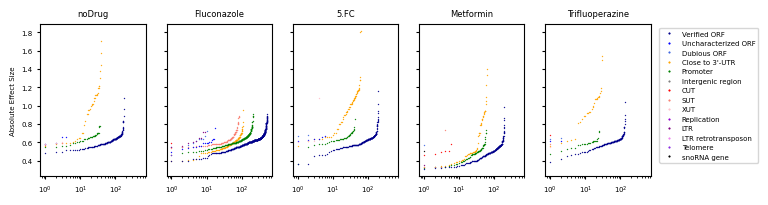

In [16]:
CM = 1/2.54 # centimeters in inches

class_down_color = {
    'Verified ORF':'darkblue',
    'Uncharacterized ORF':'blue',
    'Dubious ORF':'royalblue',
    'Close to 3\'-UTR':'orange',
    'Promoter':'green',
    'Intergenic region':'grey',
    'CUT':'red',
    'SUT':'salmon',
    'XUT':'pink',
    'Replication':'darkviolet',
    'LTR':'purple',
    'LTR retrotransposon':'violet',
    'Telomere':'blueviolet',
    'snoRNA gene':'black'
    }

piQTLs = pd.read_csv(f'{root_path}/results/05_piQTL_tables/significant_piQTLs_results_with_genome_annotations_without_MTX_peaks.csv')
piQTLs = piQTLs[piQTLs['FDR'] < 0.05].reset_index(drop=True)
piQTLs = piQTLs[~piQTLs['SNP'].isin([10455, 10456, 10468])]

piQTLs['PPI'] = [ f"{piQTLs['Condition'][idx].split('_')[0]}:{piQTLs['Condition'][idx].split('_')[1]}" for idx in piQTLs.index ]
piQTLs['DRUG'] = [ f"{piQTLs['Condition'][idx].split('_')[3]}" for idx in piQTLs.index ]
piQTLs['CDT'] = [ f"{piQTLs['Condition'][idx].split('_')[2]}:{piQTLs['Condition'][idx].split('_')[3]}" for idx in piQTLs.index ]

f, axes = plt.subplots(figsize=(20 * CM, 5 * CM), nrows=1, ncols=5, sharey=True, sharex=True)
i = 0
for DRUG in ['noDrug', 'Fluconazole', '5.FC', 'Metformin', 'Trifluoperazine' ]:
    T = piQTLs[piQTLs['Condition'].str.contains(DRUG)].reset_index(drop=True)
    T['abs_Effect'] = np.abs(T['Effect'])

    for CLASS in np.unique(T['snps_class_down']):
        TMP = T[T['snps_class_down'] == CLASS].sort_values('abs_Effect', ascending=True).reset_index(drop=True)

        sns.scatterplot(y=TMP['abs_Effect'], x=TMP.index, marker='.', linewidth=0, alpha = 0.9, color=class_down_color[CLASS], ax=axes[i])
        axes[i].set_ylabel('Absolute Effect Size')
        axes[i].set_xscale('log')
        axes[i].set_title(DRUG)
    i += 1

custom = [Line2D([], [], marker='.', color='darkblue', linestyle='None'),
         Line2D([], [], marker='.', color='blue', linestyle='None'),
         Line2D([], [], marker='.', color='royalblue', linestyle='None'),
         Line2D([], [], marker='.', color='orange', linestyle='None'),
         Line2D([], [], marker='.', color='green', linestyle='None'),
         Line2D([], [], marker='.', color='grey', linestyle='None'),
         Line2D([], [], marker='.', color='red', linestyle='None'),
         Line2D([], [], marker='.', color='salmon', linestyle='None'),
         Line2D([], [], marker='.', color='pink', linestyle='None'),
         Line2D([], [], marker='.', color='darkviolet', linestyle='None'),
         Line2D([], [], marker='.', color='purple', linestyle='None'),
         Line2D([], [], marker='.', color='violet', linestyle='None'),
         Line2D([], [], marker='.', color='blueviolet', linestyle='None'),
         Line2D([], [], marker='.', color='black', linestyle='None')
         ]

plt.legend(custom, ['Verified ORF', 'Uncharacterized ORF', 'Dubious ORF', 'Close to 3\'-UTR', 'Promoter', 'Intergenic region', 'CUT', 'SUT', 'XUT', 'Replication', 'LTR', 'LTR retrotransposon', 'Telomere', 'snoRNA gene'], bbox_to_anchor=(1.05, 1.0), loc='upper left')


plt.savefig(f'{root_path}/figures/figure_2/effect_size_distribution_all_snps_down_FDR.eps', format='eps', dpi=300)
# plt.savefig('../../figures/figure_2/effect_size_distribution_all_snps_down_FDR.png', format='png', dpi=300)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


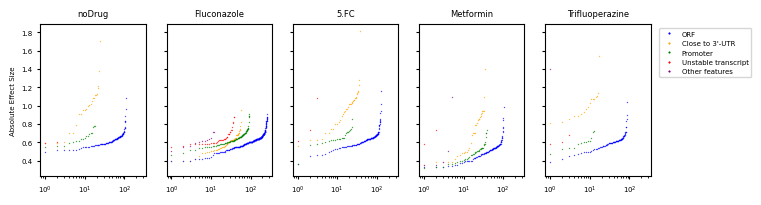

In [17]:

class_color = {
    'ORF':'blue',
    'Close to 3\'-UTR':'orange',
    'Promoter':'green',
    'Unstable transcript':'red',
    'Other features':'purple'
    }

piQTLs = pd.read_csv(f'{root_path}/results/05_piQTL_tables/significant_piQTLs_results_with_genome_annotations_without_MTX_peaks.csv')
lumped_piQTLs = piQTLs.replace('Intergenic region', 'Other features')
lumped_piQTLs = lumped_piQTLs.replace('Non-coding RNA', 'Other features')
piQTLs = lumped_piQTLs[lumped_piQTLs['FDR'] < 0.05].reset_index(drop=True)
piQTLs_without_outliers = piQTLs[~piQTLs['SNP'].isin([10435, 10456, 10458])]
piQTLs_with_LDs = piQTLs_without_outliers.sort_values(['Condition','SNP']).merge(annotated_LDs[['SNP', 'LD_block']], on='SNP').sort_values(['Condition','SNP'])

indpt_snps = []
for CDT in np.unique(piQTLs_with_LDs['Condition']):
    TMP = piQTLs_with_LDs[piQTLs_with_LDs['Condition'] == CDT].sort_values('-log_pval', ascending=False).drop_duplicates(subset='LD_block', keep='first')
    indpt_snps.append(TMP)


strongest_piQTLs = pd.concat(indpt_snps).reset_index(drop=True)

strongest_piQTLs['PPI'] = [ f"{strongest_piQTLs['Condition'][idx].split('_')[0]}:{strongest_piQTLs['Condition'][idx].split('_')[1]}" for idx in strongest_piQTLs.index ] 
strongest_piQTLs['DRUG'] = [ f"{strongest_piQTLs['Condition'][idx].split('_')[3]}" for idx in strongest_piQTLs.index ] 
strongest_piQTLs['CDT'] = [ f"{strongest_piQTLs['Condition'][idx].split('_')[2]}:{strongest_piQTLs['Condition'][idx].split('_')[3]}" for idx in strongest_piQTLs.index ] 

f, axes = plt.subplots(figsize=(20 * CM, 5 * CM), nrows=1, ncols=5, sharey=True, sharex=True)
i = 0
for DRUG in ['noDrug', 'Fluconazole', '5.FC', 'Metformin', 'Trifluoperazine' ]:
    T = strongest_piQTLs[strongest_piQTLs['Condition'].str.contains(DRUG)].reset_index(drop=True)
    T['abs_Effect'] = np.abs(T['Effect'])

    for CLASS in np.unique(T['snps_class_up']):
        TMP = T[T['snps_class_up'] == CLASS].sort_values('abs_Effect', ascending=True).reset_index(drop=True)

        sns.scatterplot(y=TMP['abs_Effect'], x=TMP.index, marker='.', linewidth=0, alpha = 0.7, color=class_color[CLASS], ax=axes[i])
        axes[i].set_ylabel('Absolute Effect Size')
        axes[i].set_xscale('log')
        axes[i].set_title(DRUG)
    i += 1

custom = [Line2D([], [], marker='.', color='blue', linestyle='None'),
        Line2D([], [], marker='.', color='orange', linestyle='None'),
        Line2D([], [], marker='.', color='green', linestyle='None'),
        Line2D([], [], marker='.', color='red', linestyle='None'),
        Line2D([], [], marker='.', color='purple', linestyle='None')]

plt.legend(custom, ['ORF', 'Close to 3\'-UTR', 'Promoter', 'Unstable transcript', 'Other features'], bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.savefig(f'{root_path}/figures/figure_2/effect_size_distribution_strongest_snps_up_FDR_without_outliers.eps', format='eps', dpi=300)
# plt.savefig('../../figures/figure_2/FIGURE_2/effect_size_distribution_strongest_snps_up_FDR_without_outliers.png', format='png', dpi=300)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


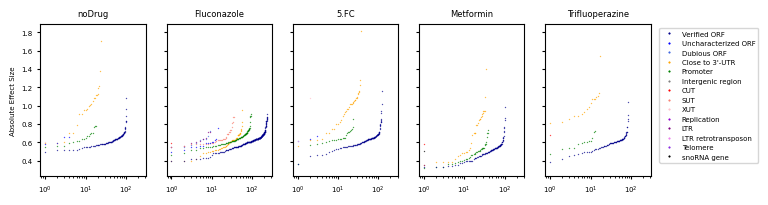

In [18]:
class_down_color = {
    'Verified ORF':'darkblue',
    'Uncharacterized ORF':'blue',
    'Dubious ORF':'royalblue',
    'Close to 3\'-UTR':'orange',
    'Promoter':'green',
    'Intergenic region':'grey',
    'CUT':'red',
    'SUT':'salmon',
    'XUT':'pink',
    'Replication':'darkviolet',
    'LTR':'purple',
    'LTR retrotransposon':'violet',
    'Telomere':'blueviolet',
    'snoRNA gene':'black'
    }

piQTLs = pd.read_csv(f'{root_path}/results/05_piQTL_tables/significant_piQTLs_results_with_genome_annotations_without_MTX_peaks.csv')
piQTLs = piQTLs[piQTLs['FDR'] < 0.05].reset_index(drop=True)
piQTLs_without_outliers = piQTLs[~piQTLs['SNP'].isin([10455, 10456, 10468])]
piQTLs_with_LDs = piQTLs_without_outliers.sort_values(['Condition','SNP']).merge(annotated_LDs[['SNP', 'LD_block']], on='SNP').sort_values(['Condition','SNP'])

indpt_snps = []
for CDT in np.unique(piQTLs_with_LDs['Condition']):
    TMP = piQTLs_with_LDs[piQTLs_with_LDs['Condition'] == CDT].sort_values('-log_pval', ascending=False).drop_duplicates(subset='LD_block', keep='first')
    indpt_snps.append(TMP)


strongest_piQTLs = pd.concat(indpt_snps).reset_index(drop=True)


f, axes = plt.subplots(figsize=(20 * CM, 5 * CM), nrows=1, ncols=5, sharey=True, sharex=True)
i = 0
for DRUG in ['noDrug', 'Fluconazole', '5.FC', 'Metformin', 'Trifluoperazine']:
    T = strongest_piQTLs[strongest_piQTLs['Condition'].str.contains(DRUG)].reset_index(drop=True)
    T['abs_Effect'] = np.abs(T['Effect'])

    for CLASS in np.unique(T['snps_class_down']):
        TMP = T[T['snps_class_down'] == CLASS].sort_values('abs_Effect', ascending=True).reset_index(drop=True)

        sns.scatterplot(y=TMP['abs_Effect'], x=TMP.index, marker='.', linewidth=0, alpha = 0.7, color=class_down_color[CLASS], ax=axes[i])
        axes[i].set_ylabel('Absolute Effect Size')
        axes[i].set_xscale('log')
        axes[i].set_title(DRUG)
    i += 1

custom = [Line2D([], [], marker='.', color='darkblue', linestyle='None'),
         Line2D([], [], marker='.', color='blue', linestyle='None'),
         Line2D([], [], marker='.', color='royalblue', linestyle='None'), 
         Line2D([], [], marker='.', color='orange', linestyle='None'),
         Line2D([], [], marker='.', color='green', linestyle='None'), 
         Line2D([], [], marker='.', color='grey', linestyle='None'),
         Line2D([], [], marker='.', color='red', linestyle='None'),
         Line2D([], [], marker='.', color='salmon', linestyle='None'), 
         Line2D([], [], marker='.', color='pink', linestyle='None'),
         Line2D([], [], marker='.', color='darkviolet', linestyle='None'),
         Line2D([], [], marker='.', color='purple', linestyle='None'),
         Line2D([], [], marker='.', color='violet', linestyle='None'), 
         Line2D([], [], marker='.', color='blueviolet', linestyle='None'),
         Line2D([], [], marker='.', color='black', linestyle='None')
         ]

plt.legend(custom, ['Verified ORF', 'Uncharacterized ORF', 'Dubious ORF', 'Close to 3\'-UTR', 'Promoter', 'Intergenic region', 'CUT', 'SUT', 'XUT', 'Replication', 'LTR', 'LTR retrotransposon', 'Telomere', 'snoRNA gene'], bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.savefig(f'{root_path}/figures/figure_2/effect_size_distribution_strongest_snps_down_FDR.eps', format='eps', dpi=300)
# plt.savefig('../../figures/figure_2/manuscript/figures/FIGURE_2/effect_size_distribution_strongest_snps_down_FDR.png', format='png', dpi=300)

In [19]:
piQTLs = pd.read_csv(f'{root_path}/results/05_piQTL_tables/significant_piQTLs_results_with_genome_annotations_without_MTX_peaks.csv')
lumped_piQTLs = piQTLs.replace('Intergenic region', 'Other features')
lumped_piQTLs = lumped_piQTLs.replace('Non-coding RNA', 'Other features')
piQTLs = lumped_piQTLs[lumped_piQTLs['FDR'] < 0.05].reset_index(drop=True)
piQTLs_without_outliers = piQTLs[~piQTLs['SNP'].isin([10455, 10456, 10468])]
piQTLs_with_LDs = piQTLs_without_outliers.sort_values(['Condition','SNP']).merge(annotated_LDs[['SNP', 'LD_block']], on='SNP').sort_values(['Condition','SNP'])

indpt_snps = []
for CDT in np.unique(piQTLs_with_LDs['Condition']):
    TMP = piQTLs_with_LDs[piQTLs_with_LDs['Condition'] == CDT].sort_values('-log_pval', ascending=False).drop_duplicates(subset='LD_block', keep='first')
    indpt_snps.append(TMP)


strongest_piQTLs = pd.concat(indpt_snps).reset_index(drop=True)

strongest_piQTLs['PPI'] = [ f"{strongest_piQTLs['Condition'][idx].split('_')[0]}:{strongest_piQTLs['Condition'][idx].split('_')[1]}" for idx in strongest_piQTLs.index ] 
strongest_piQTLs['DRUG'] = [ f"{strongest_piQTLs['Condition'][idx].split('_')[3]}" for idx in strongest_piQTLs.index ] 
strongest_piQTLs['CDT'] = [ f"{strongest_piQTLs['Condition'][idx].split('_')[2]}:{strongest_piQTLs['Condition'][idx].split('_')[3]}" for idx in strongest_piQTLs.index ] 

lumped_annotated_LDs = annotated_LDs.replace('Intergenic region', 'Other features')
lumped_annotated_LDs = lumped_annotated_LDs.replace('Non-coding RNA', 'Other features')
lumped_annotated_LDs.groupby('snps_class_up').count()

total_by_class = pd.DataFrame(lumped_annotated_LDs.groupby(['snps_class_up']).count()['SNP']).reset_index()

fraction = pd.DataFrame(strongest_piQTLs.groupby(['DRUG', 'snps_class_up']).count()['SNP']).reset_index()
fraction['DRUG'] = pd.Categorical(fraction['DRUG'], categories=['noDrug','Fluconazole', '5.FC', 'Metformin', 'Trifluoperazine'], ordered=True)
fraction = fraction.merge(total_by_class, on=['snps_class_up'], suffixes=['_frac', '_total'])
fraction['snps_class_up'] = pd.Categorical(fraction['snps_class_up'], categories=['ORF', 'Close to 3\'-UTR', 'Promoter', 'Unstable transcript', 'Other features'], ordered=True)
fraction['frac'] = fraction['SNP_frac'] / fraction['SNP_total']
fraction = fraction.sort_values(['snps_class_up', 'DRUG'])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


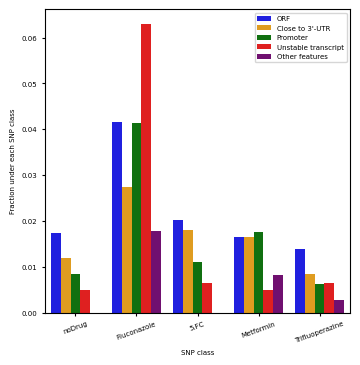

In [20]:
CM = 1/2.54 # centimeters in inches

f = plt.figure(figsize=(10*CM, 10*CM))
sns.barplot(y=fraction['frac'], x=fraction['DRUG'], hue=fraction['snps_class_up'], palette=['blue', 'orange', 'green','red','purple'])
plt.xlabel('SNP class')
plt.ylabel('Fraction under each SNP class')
plt.xticks(rotation=20)
plt.legend(loc='upper right')

# plt.savefig('../../figures/figure_2/strongest_piQTLs_distribution_fraction.png', format='png', dpi=300)
plt.savefig(f'{root_path}/figures/figure_2/strongest_piQTLs_distribution_fraction.eps', format='eps', dpi=300)